<a href="https://colab.research.google.com/github/data4class/handwrittendigits/blob/main/sentiment_CNN_NN_basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from io import StringIO

csv_inline = """Sentiment,Headline
positive,Titan posts record profit
neutral,Markets end flat
negative,XYZ Corp misses guidance
"""

df = pd.read_csv(StringIO(csv_inline))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


  Sentiment                   Headline
0  positive  Titan posts record profit
1   neutral           Markets end flat
2  negative   XYZ Corp misses guidance
Sentiment
positive    1
neutral     1
negative    1
Name: count, dtype: int64
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.1115 - val_accuracy: 1.0000 - val_loss: 1.0828
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 1.0000 - loss: 0.9955 - val_accuracy: 0.0000e+00 - val_loss: 1.0915
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 1.0000 - loss: 0.9928 - val_accuracy: 0.0000e+00 - val_loss: 1.1088
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 0.9670 - val_accuracy: 0.0000e+00 - val_loss: 1.1265
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.8615 - val_accuracy: 0.0000e+00 - val_loss: 1.1465
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.8377 - val_accuracy: 0.0000e+00 - val_loss:

Test accuracy: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Sample headline: indian stock market surges new economic reforms announced
Predicted sentiment: neutral


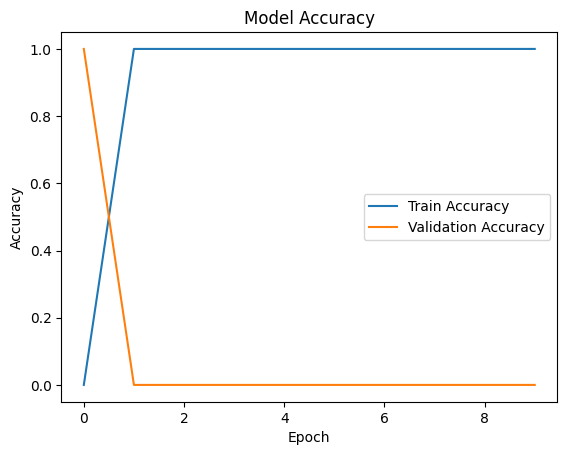

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import requests
import zipfile
import io

# Download NLTK resources
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

####### Data download ####
# Download Kaggle dataset (Sentiment Analysis for Financial News)
# Note: You need to set up Kaggle API or manually download the dataset
# Instructions: Get dataset from https://www.kaggle.com/ankurzing/sentiment-analysis-for-financial-news
# Place 'all-data.csv' in the same directory as this script
# Alternatively, use Kaggle API (uncomment below if using API)
"""
!pip install kaggle
!kaggle datasets download -d ankurzing/sentiment-analysis-for-financial-news
with zipfile.ZipFile('sentiment-analysis-for-financial-news.zip', 'r') as zip_ref:
    zip_ref.extractall('.')
"""
# Load the dataset
#df = pd.read_csv('all-data.csv', encoding='ISO-8859-1', names=['Sentiment', 'Headline'])

# Basic data inspection
print(df.head())
print(df['Sentiment'].value_counts())

####### Data preprocessing ####
# Clean text: remove stopwords and tokenize
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['Headline'] = df['Headline'].apply(preprocess_text)

# Encode labels (positive, negative, neutral)
label_encoder = LabelEncoder()
df['Sentiment'] = label_encoder.fit_transform(df['Sentiment'])
num_classes = len(label_encoder.classes_)

# Tokenize and pad sequences
max_words = 5000  # Maximum vocabulary size
max_len = 50      # Maximum sequence length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['Headline'])
sequences = tokenizer.texts_to_sequences(df['Headline'])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['Sentiment'], test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

####### Create NN and train ####
# Build a simple CNN model
model = Sequential([
    Embedding(max_words, 100, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Save the model
model.save('sentiment_cnn_model.h5')

####### Analysis and prediction ####
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')

# Predict on a sample headline
sample_headline = "Indian stock market surges as new economic reforms announced"
sample_headline = preprocess_text(sample_headline)
sample_sequence = tokenizer.texts_to_sequences([sample_headline])
sample_padded = pad_sequences(sample_sequence, maxlen=max_len, padding='post')
prediction = model.predict(sample_padded)
predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]
print(f'Sample headline: {sample_headline}')
print(f'Predicted sentiment: {predicted_label}')

# Optional: Plot training history (requires matplotlib)
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()